In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from Scattering_Simulator import pairwise_method
from Scattering_Simulator import Read_PDB
import time
import plotly.express as px
import psutil
from scipy import integrate

c:\Users\htchi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Summary 
This notebook contains code used to simulate the scattering curve of the RhuA monomer protein. 

## Load structure from PDB
Import the coordinates of the RhuA Protein from PDB. 

In [2]:
coordinates = Read_PDB.load_pdb('../Data/PDB/RhuA/1ojr.pdb1')

In [14]:
scaled_sld = coordinates[:,-1] - np.min(coordinates[:,-1])/(np.max(coordinates[:,-1]) - np.min(coordinates[:,-1]))
plotting_coords = np.hstack((coordinates[:,0:3], scaled_sld.reshape(-1,1)))
fig = px.scatter_3d(pd.DataFrame(plotting_coords, columns=['x','y','z','sld']), x ='y', y='x',z='z', color='sld', size='sld', opacity=.95, color_continuous_scale=px.colors.sequential.PuBu)

fig.update_traces(marker=dict(
                              line=dict(width=0,
                                        color='black')),
                  selector=dict(mode='markers'))

fig.update_layout(scene_camera=dict(
    eye=dict(x=1.2, y=1.2, z=0.6),
    center=dict(x=0, y=0, z=0),
    up=dict(x=3, y=3, z=0)))

fig.update_layout(coloraxis_colorbar=dict(
    title="SLD",
    thicknessmode="pixels", thickness=20,
    lenmode="pixels", len=300,
    yanchor="top", y=1,
    ticks="outside", ticksuffix="",
    dtick=8
))

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

#fig.write_image("../Images/RhuA/RhuA_Image_Test_1.png", scale=5) 

## Sample from the Structure

In [15]:
n_samples = 10000000

In [16]:
simulator = pairwise_method.scattering_simulator(n_samples)
simulator.sample_building_block(coordinates)
simulator.use_building_block_as_structure()

## Simulate the Scattering Curve

In [17]:
histogram_bins = 10000
q = np.geomspace(0.015, 0.2, 200)
I_q = simulator.simulate_scattering_curve(histogram_bins, q)

## Plot the Results

The result will be plotted and compared to the analytical solution of a sphere. A background term will be added to the simulated scattering curve. 

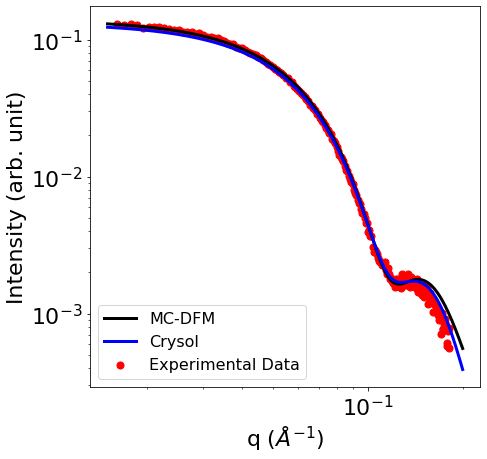

In [21]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))
exp_data = np.load('../Data/RhuA/01012_A4-T2_azoRhuA_000_sub.npy')
crysol = np.loadtxt('../Data/RhuA/RhuA_Scattering_Crysol_no_hydration_layer.txt', skiprows=1)
plt.scatter(exp_data[:,0], exp_data[:,1]*0.97, label = 'Experimental Data', s = 50, color = 'red')
plt.plot(q, I_q*6.3e3, linewidth = 3, label = 'MC-DFM', color = 'k')
plt.plot(crysol[14:-300,0], crysol[14:-300,1]*1.7e0, linewidth = 3, label = 'Crysol', color = 'blue')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.legend(fontsize=16)
#plt.savefig('../Images/RhuA/MC-DFM_RhuA.png', dpi=600, bbox_inches="tight")

(0.0, 100.0)

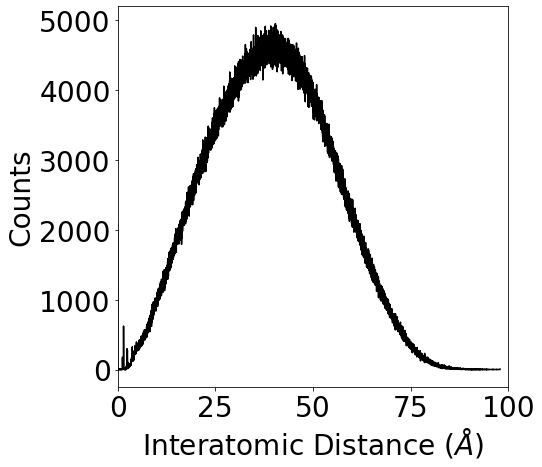

In [8]:
plt.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(figsize=(7,7))
plt.ylabel('Counts')
plt.xlabel('Interatomic Distance ($\AA$)')
lower = 0
plt.plot(simulator.r[lower:], simulator.p_r[lower:]*1e10, color='k')
plt.xlim([0, 100])
#plt.legend()
#plt.savefig('../Images/RhuA/MC-DFM_RhuA_Pairwise.png', dpi=300, bbox_inches="tight")

In [9]:
#saxs_data = np.hstack((q.reshape(-1,1), I_q_10m.reshape(-1,1)))
#filename = 'MC_DFM_RhuA_2620'
#np.save('../Data/RhuA_Time_Memory/'+ filename + '_' + str(duration)[0:5] + 's_' + '1420MB', saxs_data)
#np.save('../Data/simulated_scattering/RhuA/RhuA_Monomer.npy', saxs_data)